In [155]:
import numpy as np
import pandas as pd
import joblib
import pickle
import json
import tensorflow
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
from keras.models import load_model


import warnings
warnings.filterwarnings('ignore')




In [156]:
pipe_ml = joblib.load("pipe.pkl") 
ann_model = load_model("ann_model.h5", compile=False)

with open("label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)

scaler = joblib.load("num_scaler.pkl")

with open("ann_columns.json", "r") as f:
    ann_columns = json.load(f)

cat_cols = ann_columns["cat_cols"]
num_cols = ann_columns["num_cols"]

In [157]:

cat_cols = ann_columns["cat_cols"]
num_cols = ann_columns["num_cols"]

In [158]:
def preprocess_for_ann(df):
    # Encode categorical columns
    cat_inputs = [label_encoders[col].transform(df[col]) for col in cat_cols]
    # Scale numeric columns
    num_input = scaler.transform(df[num_cols])
    return cat_inputs + [num_input]

In [159]:
def predict_combined(df, weight_ml=0.5, weight_ann=0.5):
    """
    Takes a pandas DataFrame (like df.iloc[[0]]),
    returns weighted prediction from ML and ANN models.
    """
    # 1. ML prediction (OHE is inside pipe)
    pred_ml = np.expm1(pipe_ml.predict(df))  # Inverse of log1p
    
    # 2. ANN prediction (manual preprocessing)
    ann_input = preprocess_for_ann(df)
    pred_ann = np.expm1(ann_model.predict(ann_input))

    # 3. Weighted average
    final_pred = weight_ml * pred_ml + weight_ann * pred_ann
    
    
    
    return {
        "ML Prediction": pred_ml[0][0] if pred_ml.ndim == 2 else pred_ml[0],
        "ANN Prediction": pred_ann[0][0] if pred_ann.ndim == 2 else pred_ann[0],
        "Final Ensemble": final_pred[0][0] if final_pred.ndim == 2 else final_pred[0]
    }


In [160]:
if __name__ == "__main__":
    df = joblib.load("df.pkl")
    df_sample = df.sample(frac=0.2, random_state=42)

    X_input = df_sample.drop("Price", axis=1)
    y_true = df_sample["Price"]

    # ===== ML Prediction (fast) =====
    preds_ml = np.expm1(pipe_ml.predict(X_input))

    # ===== ANN Prediction (batch instead of row-by-row) =====
    ann_input = preprocess_for_ann(X_input)
    preds_ann = np.expm1(ann_model.predict(ann_input, verbose=0))

    # ===== Ensemble =====
    weight_ml, weight_ann = 0.6, 0.4
    preds_ensemble = weight_ml * preds_ml + weight_ann * preds_ann.reshape(-1)

    import pandas as pd

# Create DataFrame to compare predictions
comparison_df = pd.DataFrame({
    "Actual Price": y_true.values[:5].round(2),
    "ML Prediction": preds_ml[:5].round(2),
    "ANN Prediction": preds_ann[:5].flatten().round(2),
    "Ensemble Prediction": preds_ensemble[:5].round(2)
})

print("\nFirst 20 Predictions vs Actual Prices By Combined Model:\n")
print(comparison_df)





First 20 Predictions vs Actual Prices By Combined Model:

   Actual Price  ML Prediction  ANN Prediction  Ensemble Prediction
0         89084       67858.24    57362.628906             63660.00
1         61218       63145.68    62694.878906             62965.36
2         26586       22166.86    26852.429688             24041.09
3         47898       46381.98    48353.558594             47170.62
4         66280       69277.98    78746.523438             73065.40


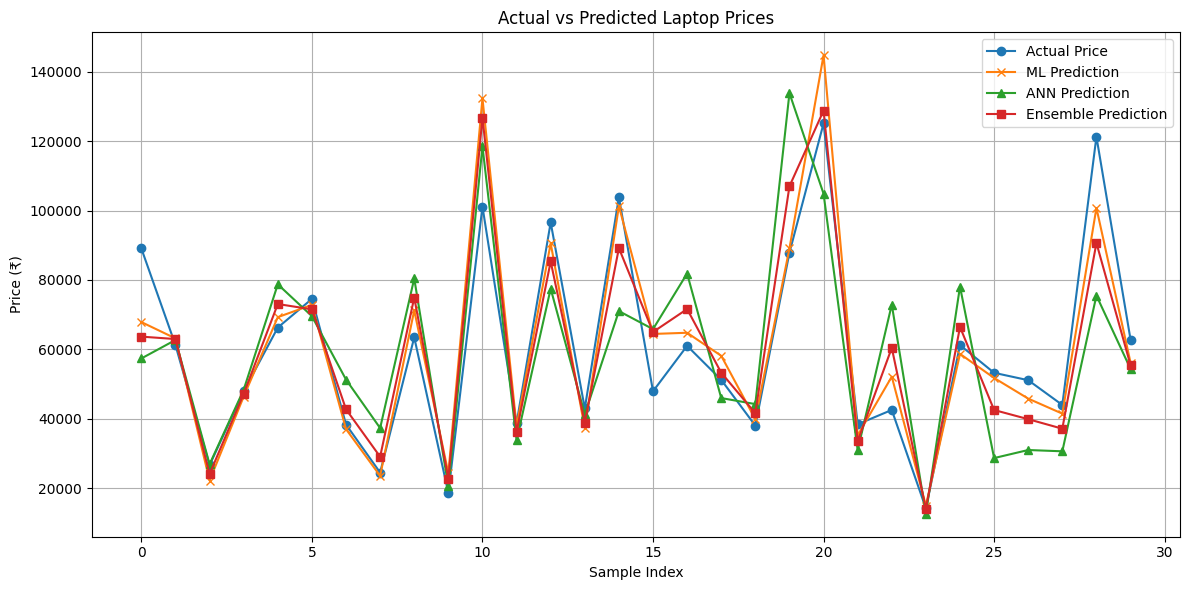

In [161]:
import matplotlib.pyplot as plt

N = 30

plt.figure(figsize=(12, 6))
plt.plot(y_true.values[:N], label="Actual Price", marker='o')
plt.plot(preds_ml[:N], label="ML Prediction", marker='x')
plt.plot(preds_ann[:N], label="ANN Prediction", marker='^')
plt.plot(preds_ensemble[:N], label="Ensemble Prediction", marker='s')

plt.title("Actual vs Predicted Laptop Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price (₹)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
